# 1. DATA PREPARATION

This notebook covers the process of data collection and pre-processing.
Python modules needed are imported here:

In [2]:
import pandas as pd # managing dataframes
import numpy as np # numerical operations
import warnings, uuid # silence warnings and anonymous patient IDs generation

from tqdm import tqdm # progress bar
from fancyimpute import KNN # KNN imputation
from sklearn.model_selection import train_test_split # train/test split
from scipy.stats import chi2_contingency # chi-squared test

### 0) RAW DATA COLLECTION

For memory purposes, the complete raw dataset collected from the NeuronUP platform are divided into 2 subsets in terms of periods of time. Before merging them, they will be pre-processed separately. 

In [17]:
df1 = pd.read_csv("data/raw_data/raw_subset_data1.csv", index_col=False)
df2 = pd.read_csv("data/raw_data/raw_subset_data2.csv", index_col=False)
df1.head()

,Unnamed: 0,patient_id,day,score,area_id,area_score,education_id,gender,birthdate
0,0,1047,2013-12-17T00:00:00.000Z,0.0,42,0.0,3.0,1.0,1961-12-21
1,1,1047,2013-12-17T00:00:00.000Z,0.0,43,0.0,3.0,1.0,1961-12-21
2,2,1047,2014-01-07T00:00:00.000Z,0.2,42,0.2,3.0,1.0,1961-12-21
3,3,1047,2014-01-07T00:00:00.000Z,0.2,43,0.2,3.0,1.0,1961-12-21
4,4,1014,2013-12-17T00:00:00.000Z,0.2,14,0.2,NaN,1.0,1982-12-29


In [16]:
df2.columns

Index(['Unnamed: 0', 'patient_id', 'day', 'score', 'area_id', 'area_score',
       'id', 'education_id', 'gender', 'birthdate'],
      dtype='object')

We can see we have different features:
- <code>patient_id</code> : Identifier of each patient (pseudoanonymized)
- <code>day</code>: Date of the record
- <code>score</code>: General score of the patient computed based on all area scores combined on that day
- <code>area_id</code>: Numeric identifier of the cognitive area trained
- <code>area_score</code>: Specific score of the area trained
- <code>id</code>: Another column identifying patient
- <code>education_id</code>: Level of education of the patient (1- , 2- ,  3- , 4- ,5- )
- <code>gender</code>: 1(Male) or 2(Female)
- <code>birthdate</code>: Patient birthdate.

### 1) DATA UNDERSTANDING

Before pre-processing the data we take a quick look to the data types of variables and a general statistical summary of them.

In [26]:
len(df1) # Total records

11772868

In [27]:
len(df2) # Total records

15729776

In [17]:
df2.dtypes

Unnamed: 0        int64
patient_id        int64
day              object
score           float64
area_id           int64
area_score      float64
id              float64
education_id    float64
gender          float64
birthdate        object
dtype: object

Some data types need to be corrected, as day and birthdate should be in datetime format and education id and gender as integers.

In [15]:
df1.describe(include='all')

,Unnamed: 0,patient_id,day,score,area_id,area_score,education_id,gender,birthdate
count,1.177287e+07,1.177287e+07,11772868,1.177287e+07,1.177287e+07,1.177287e+07,1.084253e+06,6.504866e+06,6292531
unique,NaN,NaN,2891,NaN,NaN,NaN,NaN,NaN,14520
top,NaN,NaN,2021-05-12T00:00:00.000Z,NaN,NaN,NaN,NaN,NaN,1950-03-22
freq,NaN,NaN,19299,NaN,NaN,NaN,NaN,NaN,19505
mean,5.886434e+06,5.731647e+04,NaN,4.331417e-01,3.450352e+01,4.111700e-01,3.518035e+00,1.451964e+00,NaN
std,3.398534e+06,4.483086e+04,NaN,1.838067e-01,1.680928e+01,2.661246e-01,1.085931e+00,4.976873e-01,NaN
min,0.000000e+00,4.000000e+00,NaN,0.000000e+00,1.200000e+01,0.000000e+00,1.000000e+00,1.000000e+00,NaN
25%,2.943217e+06,1.293500e+04,NaN,2.996000e-01,1.600000e+01,2.000000e-01,3.000000e+00,1.000000e+00,NaN
50%,5.886434e+06,4.744200e+04,NaN,4.258000e-01,3.400000e+01,3.670000e-01,3.000000e+00,1.000000e+00,NaN
75%,8.829650e+06,9.668700e+04,NaN,5.566000e-01,5.200000e+01,5.878000e-01,4.000000e+00,2.000000e+00,NaN


We can see scores and area scores are between 0 and 1, and we have 5 educational levels. 

### 2) DATA PRE-PROCESSING

First of all, we can get rid of useless columns for the study, as we already have a patient id and the "id" extra column is only in the second subset.

In [18]:
df2 = df2.drop("id", axis=1)

#### 2.1) Missing values

Missing values are an issue for the analysis, as most of the models don't accept them and can lead to problems in the future.

In [4]:
df1.isnull().sum()

Unnamed: 0             0
patient_id             0
day                    0
score                  0
area_id                0
area_score             0
education_id    10688615
gender           5268002
birthdate        5480337
dtype: int64

In [5]:
df2.isnull().sum()

Unnamed: 0             0
patient_id             0
day                    0
score                  0
area_id                0
area_score             0
education_id    14635221
gender          11848865
birthdate       12240189
dtype: int64

The education id column has missing values for more than 90% of records in both subsets, so we consider to remove them as a variable for the analysis. Gender and age are basic for any analysis so we will keep them and do whatever we can with them. To deal with gender and age missing values ('NaN'), we will remove all the records that don't have both of them.

In [19]:
# Drop education_id column
df1 = df1.drop("education_id", axis=1)
df2 = df2.drop("education_id", axis=1)

# Remove patients with no gender and birthdate
df1 = df1[df1['gender'].notnull()] 
df1 = df1[df1['birthdate'].notnull()] 

df2 = df2[df2['gender'].notnull()] 
df2 = df2[df2['birthdate'].notnull()] 

#### 2.2) Data formatting

Now we transform the variables into the correct format.

In [20]:
# Day and birthdate to date time format
df1['birthdate'] = pd.to_datetime(df1['birthdate'], format='%Y-%m-%d', errors='coerce').dt.strftime('%Y-%m-%d')
df1["day"] = pd.to_datetime(df1["day"], errors='coerce').dt.strftime('%Y-%m-%d')

df2['birthdate'] = pd.to_datetime(df2['birthdate'], format='%Y-%m-%d', errors='coerce').dt.strftime('%Y-%m-%d')
df2["day"] = pd.to_datetime(df2["day"], errors='coerce').dt.strftime('%Y-%m-%d')

# Gender to integer 
df1['gender'] = df1['gender'].astype('int')
df2['gender'] = df2['gender'].astype('int')


In [23]:
# Drop 'Unnamed: 0' column
df1 = df1.drop('Unnamed: 0', axis=1)
df2 = df2.drop('Unnamed: 0', axis=1)

In [25]:
df2.head()

,patient_id,day,score,area_id,area_score,gender,birthdate
0,5763,2020-01-01,0.4174,13,0.4730,1,2016-02-09
1,5763,2020-01-01,0.4174,14,0.2977,1,2016-02-09
2,5763,2020-01-01,0.4174,15,0.1667,1,2016-02-09
3,5763,2020-01-01,0.4174,16,0.2477,1,2016-02-09
4,5763,2020-01-01,0.4174,22,0.1667,1,2016-02-09


We have a file with the area names so we will transform the numbers into the actual area values, and name the column "area" instead of "area_id".

In [26]:
# Area names into the area_id column
areas_US = pd.read_csv("data/raw_data/areas_US.csv")

df1 = df1.merge(areas_US, left_on="area_id", right_on="id", how="left")
df1 = df1.drop(columns=["id","area_id"])
df1 = df1.rename(columns={'full_name': 'area'})
df1 = df1[['day', 'patient_id', 'score', 'area', 'area_score', 'gender', 'birthdate']]

df2 = df2.merge(areas_US, left_on="area_id", right_on="id", how="left")
df2 = df2.drop(columns=["id","area_id"])
df2 = df2.rename(columns={'full_name': 'area'})
df2 = df2[['day', 'patient_id', 'score', 'area', 'area_score', 'gender', 'birthdate']]

In [29]:
df1.head()

,day,patient_id,score,area,area_score,gender,birthdate
0,2013-12-17,1047,0.0,Gnosis,0.0,1,1961-12-21
1,2013-12-17,1047,0.0,Visual Gnosis,0.0,1,1961-12-21
2,2014-01-07,1047,0.2,Gnosis,0.2,1,1961-12-21
3,2014-01-07,1047,0.2,Visual Gnosis,0.2,1,1961-12-21
4,2013-12-17,1014,0.2,Attention,0.2,1,1982-12-29


A problem here for the future model is that we have more than one row per day and patient, as we have different records for each area score on that specific day. The solution here can be to create a column for each area and assign a score there in case it has been played that day. 

The process is done separately for each subset and with chunks, as it is computationally expensive. 

Several hours are needed for each subset, and progress bar is added to check the progress. To keep the result, we save the resulting files as 'subset1_areas.csv' and 'subset2_areas.csv'.

In [ ]:
# SUBSET 1
warnings.filterwarnings("ignore")

chunk_size = 20000
chunks1 = [df1[i:i + chunk_size] for i in range(0, len(df1), chunk_size)]

pbar = tqdm(total = len(chunks1), desc="Processing Chunks")

for i,chunk in enumerate(chunks1):
        # Turn areas into individual columns and fill with NaN
    areas1 = chunk["area"].unique()
    areas1 = sorted(areas1)
      
    # Take all days where a patient has the area and put the area score corresponding to that area in its column
    patients1 = chunk["patient_id"].unique()
    
    for area in list(areas1):
      chunk[area] = 'NaN' 
      for patient in list(patients1):
        mask = (chunk["patient_id"] == patient) & (chunk["area"] == area)
        chunk[area][mask] = chunk["area_score"][mask]
        
    pbar.update(1)

pbar.close()

result_df1 = pd.concat(chunks1, ignore_index=True)

In [ ]:
# SUBSET 2
warnings.filterwarnings("ignore")

chunk_size = 10000
chunks2 = [df2[i:i + chunk_size] for i in range(0, len(df2), chunk_size)]

pbar = tqdm(total = len(chunks2), desc="Processing Chunks")

for i,chunk in enumerate(chunks2):
        # Turn areas into individual columns and fill with NaN
    areas2 = chunk["area"].unique()
    areas2 = sorted(areas2)
      
    # Take all days where a patient has the area and put the area score corresponding to that area in its column
    patients2 = chunk["patient_id"].unique()
    
    for area in list(areas2):
      chunk[area] = 'NaN' 
      for patient in list(patients2):
        mask = (chunk["patient_id"] == patient) & (chunk["area"] == area)
        chunk[area][mask] = chunk["area_score"][mask]
        # print(f"Area {area} done in pa
    # print(f"Chunk {i} of {len(chunks)} finished!")
    pbar.update(1)

pbar.close()

result_df2 = pd.concat(chunks2, ignore_index=True)

In [ ]:
# Save new files:
# result_df1.to_csv('data/subset1_areas.csv', index = False) 
# result_df2.to_csv('data/subset2_areas.csv', index = False) 

After this is completed, we still have more than one record per patient and day, so we merge the area scores all in the same day. Then we can remove the area and area_score columns, and finally merge both subsets into one.

Finally, we need to check if we have duplicated values between both subsets as a result of their intersection, and eliminate them. A new file is saved as <code>initial_clean_data.csv</code>.

In [13]:
df1_pivoted = df1.pivot(index=['day','patient_id', 'score', 'gender', 'birthdate'],columns='area', values='area_score').reset_index()
df2_pivoted = df2.pivot(index=['day','patient_id', 'score', 'gender', 'birthdate'],columns='area', values='area_score').reset_index()

In [31]:
merged_df = pd.concat([df1_pivoted, df2_pivoted], ignore_index=True, sort=False)
duplicated = merged_df.duplicated(['day','patient_id'])
len(duplicated)

In [33]:
clean_data = merged_df.drop_duplicates(['day', 'patient_id']) # intersection --> duplicated ones during the process (subsets solapados)


In [39]:
# A new file is saved:

# clean_data.to_csv('data/initial_clean_data.csv', index=False)


The final file has both subsets merged with one record per patient and day, and new columns for each area that assign the score. Now we have a lot of missing values that can cause problems for the model, but this can be applied before applying the model to decide which is the best strategy to use.

-----------------------------

### 2.3) Filtering patients in terms of time points

As the objective is to develop a predictive model and we are working with time series data, we should check how irregular the data is, as depending on the patient we will have data from more days or more frequent data in certain periods of time. The model is applied separately to each patient, so we need to have a minimum of data for the model to work.

In [40]:
clean_data = pd.read_csv("data/initial_clean_data.csv")

#### 2.3.1) Distribution of days per patient

In [41]:
patient_days = clean_data['patient_id'].value_counts().reset_index()
patient_days.columns = ['patient_id', 'days_played']

In [42]:
patient_days

,patient_id,days_played
0,11858,1579
1,11010,1345
2,6373,1320
3,19563,1241
4,9664,1238
...,...,...
19637,126166,1
19638,12495,1
19639,53784,1
19640,15528,1


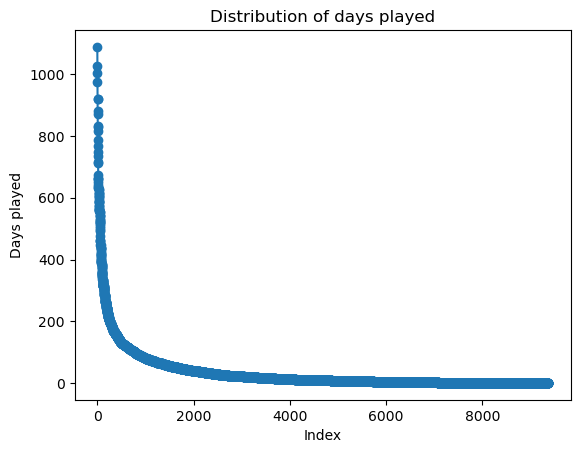

In [35]:
# Distribution of days_played
plt.plot(patient_days['days_played'], marker='o')
plt.xlabel('Index')
plt.ylabel('Days played')
plt.title('Distribution of days played')
plt.show()

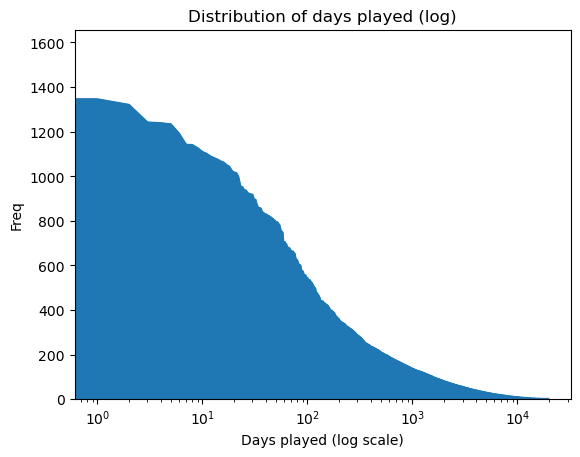

In [49]:
# Log distribution
data = patient_days["days_played"]
data.plot(kind='area')
plt.xscale('log') # Log distribution
plt.xlabel('Days played (log scale)')
plt.ylabel('Freq')
plt.title('Distribution of days played (log)')
plt.show()

In [51]:
np.median(patient_days["days_played"])

9.0

We see that most of the patients have a few days played, and considering these days are not consecutive, this can lead to problems for the model to understand the data. In this case, we can consider to compact the daily data into weeks for each patient to be more solid, and do the mean of scores for that week.

#### 2.3.2) Weekly data for patients

We will create a new column <code>week</code> and fill it with the week. Then, we will take all days from that week for each patient and calculate the mean of scores of that week. A new file <code>weekly_data.csv</code> is created.

In [52]:
# Create a new week column
uniform_data = clean_data

uniform_data['day'] = pd.to_datetime(uniform_data['day'])
uniform_data['week'] = uniform_data['day'].dt.strftime('%U-%Y')

column_to_move = uniform_data.pop("week")

uniform_data.insert(0, "week", column_to_move)

In [54]:
mean_data = pd.DataFrame()
uniform = uniform_data.groupby(['patient_id', 'week'])

mean_data['score'] = uniform['score'].mean()
mean_data['gender'] = uniform['gender'].first()
mean_data['birthdate'] = uniform['birthdate'].first()

for col in uniform_data.columns[6:]:
    mean_data[col] = uniform[col].mean()

In [55]:
mean_data.reset_index(inplace=True)
mean_data.head()

In [58]:
# mean_data.to_csv("data/weekly_data.csv")

In [59]:
patient_weeks = mean_data['patient_id'].value_counts().reset_index()
patient_weeks.columns = ['patient_id', 'weeks_played']

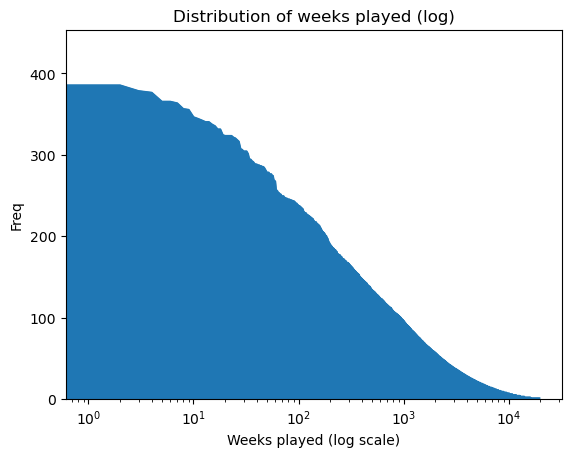

In [60]:
# log distribution
week_data = patient_weeks["weeks_played"]
week_data.plot(kind='area')
plt.xscale('log') # Log distribution
plt.xlabel('Weeks played (log scale)')
plt.ylabel('Freq')
plt.title('Distribution of weeks played (log)')
plt.show()

We will use this value later for filtering:

In [61]:
np.median(patient_weeks["weeks_played"])

7.0

----------------------

#### 2.3.3) Anonymising patients

Patients are already pseudoanonymized. Even though, to fully deal with sensitive data we can anonymise their ids, and save it as a new file <code>weekly_anonymous</code>.

In [16]:
mean_data = pd.read_csv("data/weekly_data.csv")
unique_patients = mean_data['patient_id'].unique()
len(unique_patients)

19642

In [4]:
# Create a list of 8 digit alphanumerical ids
ids = []
# Create a set of seen ids to avoid duplicates
seen = set()
for i in range(19642): # Change this to the number of ids you need
    # Generate a random uuid
    uid = uuid.uuid4()
    # Convert it to a string and take the first 8 characters
    id = str(uid)[:8]
    # Check if the id is already in the set
    if id not in seen:
        # Add the id to the set
        seen.add(id)
        # Append the id to the list
        ids.append(id)
# Print the list
print(ids)


['39134d74', '83e9021b', '61adc2cc', 'f44bab4a', 'de7cb5e3', 'fc180b9d', '0aeaef31', 'b13fd4a3', '2cccfdd5', '03f84e4b', '1e43205d', '56d06764', '5e3175d5', 'c26d1d59', 'fdedd3cc', 'edf5dfc1', 'd7bbec56', '7bc6e27d', '2249c64b', '6148879b', '9aef7a04', '7208a9a2', '416910ab', '70ffec7e', '0a1d0a28', 'e99dae7a', 'e05868f8', '1b37dcbf', '6221ba39', 'ce205f7b', 'bf8c726f', '8f9497a6', '1779886d', '70d58948', '5ca11687', '751e16b6', 'de4688b0', '081cae65', '23cdb490', '7c50d59e', 'ba89898b', '2add0fcf', '98afce14', '87477cd5', 'cdefb47d', '09dd6aa1', 'd1148258', 'd8a9bae1', 'fe63662e', '30444ab2', 'dcadbd30', '4a6c83c8', '8f0919a4', '99662288', '45edf614', 'd06db82b', 'd445a711', '12acfec4', 'd57ab5c4', 'e85d5fad', '589fb6e6', '4e121c03', '01c6b026', '5eda8082', 'c4555f6d', '55934728', 'c387158b', 'f5005171', '0912a9bd', '0632dcdd', '380f6982', 'ef0af3cf', 'e19272f5', '3c962119', '1a054cb7', '81512626', '588924b1', 'ea87d031', '904ce5bb', 'ebed31f6', '2cf76084', 'df4d7a9a', 'c7d8985b', '7b

In [17]:
# OPTION TO ANONYMIZE PATIENTS
# Create a dictionary that maps the patient_ids to the alphanumerical ids
id_map = dict(zip(mean_data['patient_id'].unique(), ids))
# Use the map function to replace the patient_ids with the alphanumerical ids
mean_data['anonymous_id'] = mean_data['patient_id'].map(id_map)
mean_data['patient_id'] = mean_data['anonymous_id']
anonymous_weekly_data = mean_data.drop(mean_data[['anonymous_id']], axis=1)

In [26]:
anonymous_weekly_data = anonymous_weekly_data.drop("Unnamed: 0", axis=1)

In [27]:
anonymous_weekly_data.columns[0]

'patient_id'

In [28]:
# anonymous_weekly_data.to_csv('data/weekly_anonymous.csv', index=False)

----------------------------

### 2.4) Bining categories into groups
Object types are not supported by most models, so we can turn birthdate into different categories, let's say  0 for preescolar, 1 for children, 2 for teenagers, 3 for young adults, 4 for middle age adults, 5 for senior adults. A new file is saved as <code>weekly_anonymous_bining</code>, and it will be used for the model.


In [29]:
df = pd.read_csv('data/weekly_anonymous.csv')

In [30]:
df.isnull().sum() #still some NaN in birthdate

patient_id                      0
week                            0
score                           0
gender                          0
birthdate                     479
Alternating Attention      347884
Attention                   52997
Auditory Gnosis            402442
Body Schema                389014
Comprehension              341861
Decision Making            398970
Discrimination             373167
Episodic Memory            226766
Executive Functions         49117
Expression                 385274
Flexibility                307041
Gnosis                     252229
Hemineglect                214684
Inhibition                 241634
Language                   186095
Memory                     166294
Naming                     406800
Orientation                379471
Place Orientation          394759
Planning                   188383
Praxis                     389897
Processing Speed           183717
Reading                    371002
Reasoning                  258935
Selective Atte

In [31]:
df = df[df['birthdate'].notnull()]

In [32]:
current_year = 2023
df2 = df.copy()
df2['birth_year'] = pd.to_datetime(df2['birthdate']).dt.year

df2 = df2.dropna(subset=['birth_year'])
df2 = df2[(df2['birth_year'] >= 1900) & (df2['birth_year'] <= current_year)] # no unreal ages

df2["age"] = current_year - df2['birth_year']
bins = [0, 5, 11, 18, 34, 64, 123]
labels = ["Preescolar(0-5)", "Children(6-11)", "Teenagers(12-18)", "Young Adults(19-34)", "Middle-Aged Adults(35-64)", "Senior Adults(>65)"]


df2['age_group'] = pd.cut(df2['age'], bins=bins, labels=labels, right=False)

In [33]:
df2['age'].unique()

array([ 60,  32,  61,  73,  58,  37,  64,  53,  72,  59,  50,  56,  63,
        70,  57,  75,  49,  43,  76,  21,  68,  66,  51,  52,  45,  26,
        48,  65,  74,  24,  69,  27,  25,  34,  23,  29,  36,  46,  99,
        28,  83,  35,  78,  67,  10,  62,  42,  12,  91,  71,  55,  47,
        41,  44,  39,  79,  84,  81,  16,  20,  80,  95,  40,  54,  38,
        88,  97,  96, 101,  98, 100, 102,  82,  30,  22,  85,  15,  77,
        31,  19,  13,   9,   7,  87,  17,  93,  92,  90,  89,  33,  14,
        18, 110,  86,   8,  94, 103,  11,   0, 105,   6, 109,   4,   3,
         5, 115,   1,   2], dtype=int64)

In [34]:
df2 = df2.drop(['birthdate', 'birth_year', 'age'], axis=1)

# Move 'age_group' to the 5th column
cols = list(df2.columns)
cols.remove('age_group')
cols.insert(4, 'age_group')

df2 = df2[cols]
df2 = df2[df2['age_group'].notnull()] 

# # Define the mapping for replacement in age_group column
# age_group_binning = {
#     'Preescolar(0-5)': 0,
#     'Children(6-11)': 1,
#     'Teenagers(12-18)': 2,
#     'Young Adults(19-34)': 3,
#     'Middle-Aged Adults(35-64)': 4,
#     'Senior Adults(>65)': 5
# }

# df2['age_group'] = df2['age_group'].replace(age_group_binning)

In [35]:
# Perform one-hot encoding
df_encoded = pd.get_dummies(df2, columns=['age_group'], prefix=['age'])

# Display the encoded dataframe
print(df_encoded)

       patient_id     week     score  gender  Alternating Attention  \
0        39134d74  26-2014  0.572233       1                    NaN   
1        39134d74  27-2014  0.703333       1                    NaN   
2        39134d74  28-2014  0.628350       1                    NaN   
3        39134d74  29-2014  0.000000       1                    NaN   
4        39134d74  31-2014  0.576000       1                    NaN   
...           ...      ...       ...     ...                    ...   
417531   cd274fb2  37-2023  0.403000       1                 0.3467   
417532   cd274fb2  38-2023  0.343650       1                 0.4216   
417533   cd274fb2  39-2023  0.492100       1                 0.4147   
417534   cd274fb2  40-2023  0.602000       1                 0.5916   
417535   cd274fb2  41-2023  0.491450       1                 0.8200   

        Attention  Auditory Gnosis  Body Schema  Comprehension  \
0        0.800000              NaN          NaN            NaN   
1        0.7033

In [37]:
# df_encoded.to_csv('data/weekly_anonymous_bining.csv', index=False)

-----------------------

### 2.5) Adjustments for Deep Learning models
After the EDA (see <code>EDA_general_data</code> notebook) we can make the last preparations to the data. As deep learning models need a decent amount of data to extract patterns, we will filter out patients with low activity, and take the median of weeks played as minimum (7 weeks).
Finally, all NaN values in the areas can affect the model, so we fill them using KNN imputation


In [4]:
series = pd.read_csv("data/weekly_anonymous_bining.csv")
series.head()

,patient_id,week,score,gender,Alternating Attention,Attention,Auditory Gnosis,Body Schema,Comprehension,Decision Making,...,Visuospatial Skills,Vocabulary,Working M.,Writing,age_Preescolar(0-5),age_Children(6-11),age_Teenagers(12-18),age_Young Adults(19-34),age_Middle-Aged Adults(35-64),age_Senior Adults(>65)
0,39134d74,26-2014,0.572233,1,NaN,0.800000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0
1,39134d74,27-2014,0.703333,1,NaN,0.703333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0
2,39134d74,28-2014,0.628350,1,NaN,0.800000,NaN,NaN,NaN,NaN,...,NaN,0.8,0.0,0.65,0,0,0,0,1,0
3,39134d74,29-2014,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0
4,39134d74,31-2014,0.576000,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0


In [6]:
patient_weeks =series['patient_id'].value_counts().reset_index()
patient_weeks.columns = ['patient_id', 'weeks_played']
np.median(patient_weeks["weeks_played"])

7.0

In [8]:
# Take patients with minimum 7 weeks (median value)
patient_counts = series['patient_id'].value_counts()
selected_patients = patient_counts[patient_counts >= 7].index

series = series[series['patient_id'].isin(selected_patients)]

In [21]:
series1 = series[['Attention', 'Memory', 'Orientation', 'Gnosis', 'Praxis',
                  'Language', 'Executive Functions', 'Visuospatial Skills',
                  'Social Cognition']]


We will use this dataframe for the EDA on the 7 week data, as future modifications won't let do the EDA:

In [ ]:
# series.to_csv("data/7week_EDA.csv", index=False) # File for 7week EDA, a

In [27]:
nan_counts_per_column = series1.isna().sum()*100/len(series)
nan_counts_per_column

Attention              12.194131
Memory                 39.080492
Orientation            90.697740
Gnosis                 59.586538
Praxis                 93.270378
Language               43.509932
Executive Functions    11.181424
Visuospatial Skills    60.189022
Social Cognition       90.375679
dtype: float64

In [ ]:
sequences = [
        'Attention', 'Memory', 'Orientation', 'Gnosis', 'Praxis',
        'Language', 'Executive Functions', 'Visuospatial Skills',
        'Social Cognition'
        # ... Add other variables here
    ]

##### KNN IMPUTATION

In [76]:
# Extract the relevant columns for KNN imputation
columns_for_knn = ['Alternating Attention', 'Attention', 'Auditory Gnosis', 'Body Schema', 'Comprehension', 'Decision Making',
                    'Discrimination', 'Episodic Memory', 'Executive Functions', 'Expression', 'Flexibility', 'Gnosis', 'Hemineglect', 'Inhibition',
                    'Language', 'Memory', 'Naming', 'Orientation', 'Place Orientation', 'Planning', 'Praxis', 'Processing Speed', 'Reading', 'Reasoning',
                    'Selective Attention', 'Semantic Memory', 'Social Cognition', 'Spatial Relation', 'Spatial Visualization', 'Sustained Attention',
                    'Time Estimation', 'Time Orientation', 'Visoconstructive Praxis', 'Visual Gnosis', 'Visuospatial Skills', 'Vocabulary', 'Working M.',
                    'Writing']


# Apply KNN imputation for each patient separately
patients = series['patient_id'].unique()

for patient_id in patients:
    patient_data = series[series['patient_id'] == patient_id][columns_for_knn].values
    filled_data = KNN(k=3).fit_transform(patient_data)
    
    # Update the original DataFrame with the filled values
    series.loc[series['patient_id'] == patient_id, columns_for_knn] = filled_data

# Check if there are still any NaN values
nan_counts = series[columns_for_knn].isna().sum()
print(nan_counts)

Imputing row 1/7 with 31 missing, elapsed time: 0.000
[KNN] Warning: 170/266 still missing after imputation, replacing with 0
Imputing row 1/119 with 36 missing, elapsed time: 0.000
Imputing row 101/119 with 36 missing, elapsed time: 0.033
[KNN] Warning: 884/4522 still missing after imputation, replacing with 0
Imputing row 1/164 with 35 missing, elapsed time: 0.000
Imputing row 101/164 with 32 missing, elapsed time: 0.042
[KNN] Warning: 2071/6232 still missing after imputation, replacing with 0
Imputing row 1/34 with 36 missing, elapsed time: 0.008
[KNN] Warning: 793/1292 still missing after imputation, replacing with 0
Imputing row 1/128 with 33 missing, elapsed time: 0.000
Imputing row 101/128 with 36 missing, elapsed time: 0.031
[KNN] Warning: 1461/4864 still missing after imputation, replacing with 0
Imputing row 1/142 with 35 missing, elapsed time: 0.006
Imputing row 101/142 with 34 missing, elapsed time: 0.041
[KNN] Warning: 1600/5396 still missing after imputation, replacing wi

In [43]:
# series.to_csv("data/7week.csv",index=False)

--------------------------------

### Last adjustments
We check again the data types (and correct them if needed), and check that the sorted order is correct by patient_id and week(+year).

In [44]:
series.dtypes # week has to be datetime

patient_id                        object
week                              object
score                            float64
gender                             int64
Alternating Attention            float64
Attention                        float64
Auditory Gnosis                  float64
Body Schema                      float64
Comprehension                    float64
Decision Making                  float64
Discrimination                   float64
Episodic Memory                  float64
Executive Functions              float64
Expression                       float64
Flexibility                      float64
Gnosis                           float64
Hemineglect                      float64
Inhibition                       float64
Language                         float64
Memory                           float64
Naming                           float64
Orientation                      float64
Place Orientation                float64
Planning                         float64
Praxis          

In [79]:
series2 = series.copy()

In [80]:
# Add a specific day (e.g., Monday) to 'week' values
series2['week'] = '1-' + series2['week']

# Convert 'week' column to a datetime format
series2['week'] = pd.to_datetime(series2['week'], format='%w-%W-%Y')

# Sort the DataFrame by 'patient_id' and 'week'
series2 = series2.sort_values(by=['patient_id', 'week'])

series2 = series2.reset_index(drop=True)

# Print the sorted DataFrame
print(series2)

       patient_id       week   score  gender  Alternating Attention  \
0        0012cf23 2014-10-20  1.0000       1               0.707859   
1        0012cf23 2014-10-27  0.6034       1               0.267794   
2        0012cf23 2014-11-03  0.5475       1               0.137778   
3        0012cf23 2014-11-10  0.7000       1               0.144177   
4        0012cf23 2014-11-17  0.6972       1               0.222470   
...           ...        ...     ...     ...                    ...   
389051   ffea3abc 2016-06-27  0.1674       1               0.000000   
389052   ffea3abc 2016-11-14  0.2763       1               0.000000   
389053   ffea3abc 2016-12-12  0.3207       1               0.000000   
389054   ffea3abc 2017-03-20  0.3398       1               0.000000   
389055   ffea3abc 2017-03-27  0.2700       1               0.000000   

        Attention  Auditory Gnosis  Body Schema  Comprehension  \
0        0.764433              0.0          0.0            0.0   
1        0.5400

In [81]:
# Convert 'week' column to datetime format
series2['week'] = pd.to_datetime(series2['week'])


In [82]:
# GENDER AS MALE 0 AND FEMALE 1

series2['gender'] = series2['gender'].replace({1: 0, 2: 1})

In [103]:
# Count the number of zeros in each column
zero_counts = (series2 == 0).sum()

print(zero_counts)

zero_counts_df = pd.DataFrame({'Column': zero_counts.index, 'Zero Count': zero_counts.values})

print(zero_counts_df)

patient_id                            0
week                                  0
score                                15
gender                                0
Alternating Attention             73304
Attention                             0
Auditory Gnosis                  167185
Body Schema                      120394
Comprehension                     44538
Decision Making                  149220
Discrimination                    79564
Episodic Memory                    3872
Executive Functions                   0
Expression                       101305
Flexibility                       31058
Gnosis                                0
Hemineglect                        4380
Inhibition                         9402
Language                              0
Memory                                0
Naming                           193834
Orientation                      126337
Place Orientation                149077
Planning                           4319
Praxis                           106222


In [ ]:
# Filter the DataFrame to include only the specified columns
sequences = [
        'Attention', 'Memory', 'Orientation', 'Gnosis', 'Praxis',
        'Language', 'Executive Functions', 'Visuospatial Skills',
        'Social Cognition'
        # ... Add other variables here
    ]
# Filter the DataFrame to include only the specified columns
filtered_zero_counts_df = zero_counts_df[zero_counts_df['Column'].isin(sequences)]

print(filtered_zero_counts_df)

In [100]:
areas = ['Attention', 'Executive Functions', 'Gnosis', 'Language', 'Memory', 'Visuospatial Skills']
# Create a boolean mask to identify rows where any column in 'sequences' has a value of 0
mask = (series[areas] != 0).all(axis=1)

# Apply the mask to filter the DataFrame
filtered_series = series[mask]

print(filtered_series)

       patient_id     week   score  gender  Alternating Attention  Attention  \
12       f44bab4a  02-2015  0.3750       2                  0.000   0.323250   
13       f44bab4a  02-2016  0.5250       2                  0.000   0.700000   
16       f44bab4a  04-2016  0.1409       2                  0.000   0.149700   
18       f44bab4a  04-2018  0.0494       2                  0.000   0.049400   
19       f44bab4a  05-2016  0.1700       2                  0.000   0.170000   
...           ...      ...     ...     ...                    ...        ...   
413236   fa3959f4  35-2023  0.3902       2                  0.492   0.219300   
413237   fa3959f4  36-2023  0.3776       2                  0.492   0.395500   
413238   fa3959f4  37-2023  0.5238       2                  0.492   0.523800   
413239   fa3959f4  38-2023  0.1850       2                  0.492   0.507733   
413240   fa3959f4  39-2023  0.5163       2                  0.492   0.489000   

        Auditory Gnosis  Body Schema  C

In [110]:
filtered_series = filtered_series.drop(['Alternating Attention','Auditory Gnosis', 'Body Schema', 'Comprehension',
       'Decision Making', 'Discrimination', 'Episodic Memory',
       'Expression', 'Flexibility', 
       'Hemineglect', 'Inhibition', 'Naming',
       'Orientation', 'Place Orientation', 'Planning', 'Praxis',
       'Processing Speed', 'Reading', 'Reasoning', 'Selective Attention',
       'Semantic Memory', 'Social Cognition', 'Spatial Relation',
       'Spatial Visualization', 'Sustained Attention', 'Time Estimation',
       'Time Orientation', 'Visoconstructive Praxis', 'Visual Gnosis', 'Vocabulary', 'Working M.', 'Writing'], axis=1)

In [111]:
# filtered_series.to_csv("data/final_clean_data.csv", index=False)

-----------------------------------

## COHORT SELECTION FOR TRAINING/TESTING AND EVALUATING REPRODUCIBILITY

Data is divided in 4 cohorts using stratification for age-group and gender proportions (chi-squared tests):
- 1 cohort for model training and hyper parameter tuning
- 3 models for predictions and model comparisons

In [119]:
df3 = pd.read_csv("data/final_clean_data.csv")

In [120]:
# TWO DATASETS, ONE FOR TRAIN/VALIDATION/TESTING AND OTHER TO EVALUATE REPRODUCIBILITY
# Combine age groups into a single column
df3['age_group'] = (
    df3['age_Preescolar(0-5)'] * 1 + 
    df3['age_Children(6-11)'] * 2 + 
    df3['age_Teenagers(12-18)'] * 3 + 
    df3['age_Young Adults(19-34)'] * 4 + 
    df3['age_Middle-Aged Adults(35-64)'] * 5 + 
    df3['age_Senior Adults(>65)'] * 6
)

# Combine gender and age group into a single target variable
df3['combined_target'] = df3['gender'].astype(str) + '_' + df3['age_group'].astype(str)

# Create a DataFrame with unique patient_ids and their corresponding combined_target values
unique_patients = df3[['patient_id', 'combined_target']].drop_duplicates()

# Split the unique patients into train and test sets while stratifying by combined_target
train_patients, test_patients = train_test_split(unique_patients, test_size=0.5, stratify=unique_patients['combined_target'], random_state=42)

# Merge the split patient_ids back with the original DataFrame to get the final train and test sets
split1 = pd.merge(df3, train_patients, on='patient_id')
split2 = pd.merge(df3, test_patients, on='patient_id')

# Drop the 'combined_target_y' column, which is added during the merge
split1.drop(columns=['combined_target_y'], inplace=True)
split2.drop(columns=['combined_target_y'], inplace=True)

# Rename the 'combined_target_x' column to 'combined_target'
split1.rename(columns={'combined_target_x': 'combined_target'}, inplace=True)
split2.rename(columns={'combined_target_x': 'combined_target'}, inplace=True)

# Get unique 'gender' and 'age_group' values per patient 
unique_gender_train = split1.groupby('patient_id')['gender'].first()
unique_age_group_train = split1.groupby('patient_id')['age_group'].first()

# Get unique 'gender' and 'age_group' values per patient 
unique_gender_test = split2.groupby('patient_id')['gender'].first()
unique_age_group_test = split2.groupby('patient_id')['age_group'].first()

In [121]:
# GENDER CHI-SQUARE TEST
# Calculate proportions for 'gender' in the training set
proportions_train = unique_gender_train.value_counts(normalize=True)

# Calculate proportions for 'gender' in the test set
proportions_test = unique_gender_test.value_counts(normalize=True)

# Create a DataFrame to hold the proportions
proportions_df = pd.DataFrame({'Train': proportions_train, 'Test': proportions_test})

# Perform the chi-square test for proportions
chi2_stat, p_value, _, _ = chi2_contingency(proportions_df)

# Display the results
print(f'Chi-square Test for Gender Proportions: Chi2-statistic = {chi2_stat}, p-value = {p_value}')


Chi-square Test for Gender Proportions: Chi2-statistic = 0.0, p-value = 1.0


In [122]:
# AGE_GROUP CHI-SQUARE TEST
# Calculate proportions for 'age_group' in the training set
proportions_train = unique_age_group_train.value_counts(normalize=True)

# Calculate proportions for 'age_group' in the test set
proportions_test = unique_age_group_test.value_counts(normalize=True)

# Create a DataFrame to hold the proportions
proportions_df = pd.DataFrame({'Train': proportions_train, 'Test': proportions_test})

# Perform the chi-square test for proportions
chi2_stat, p_value, _, _ = chi2_contingency(proportions_df)

# Display the results
print(f'Chi-square Test for Age Group Proportions: Chi2-statistic = {chi2_stat}, p-value = {p_value}')

Chi-square Test for Age Group Proportions: Chi2-statistic = 4.449753073955947e-06, p-value = 0.9999999999999978


Now we iteratively do the same process until we obtain 4 cohorts.

In [123]:
# Create a DataFrame with unique patient_ids and their corresponding combined_target values
unique_patients1 = split1[['patient_id', 'combined_target']].drop_duplicates()

# Split the unique patients into train and test sets while stratifying by combined_target
train_patients, test_patients = train_test_split(unique_patients1, test_size=0.5, stratify=unique_patients1['combined_target'], random_state=42)

# Merge the split patient_ids back with the original DataFrame to get the final train and test sets
split3 = pd.merge(split1, train_patients, on='patient_id')
split4 = pd.merge(split1, test_patients, on='patient_id')

# Drop the 'combined_target_y' column, which is added during the merge
split3.drop(columns=['combined_target_y'], inplace=True)
split4.drop(columns=['combined_target_y'], inplace=True)

# Rename the 'combined_target_x' column to 'combined_target'
split3.rename(columns={'combined_target_x': 'combined_target'}, inplace=True)
split4.rename(columns={'combined_target_x': 'combined_target'}, inplace=True)

# Get unique 'gender' and 'age_group' values per patient 
unique_gender_train = split3.groupby('patient_id')['gender'].first()
unique_age_group_train = split3.groupby('patient_id')['age_group'].first()

# Get unique 'gender' and 'age_group' values per patient 
unique_gender_test = split4.groupby('patient_id')['gender'].first()
unique_age_group_test = split4.groupby('patient_id')['age_group'].first()


# GENDER CHI-SQUARE TEST
# Calculate proportions for 'gender' in the training set
proportions_train = unique_gender_train.value_counts(normalize=True)

# Calculate proportions for 'gender' in the test set
proportions_test = unique_gender_test.value_counts(normalize=True)

# Create a DataFrame to hold the proportions
proportions_df = pd.DataFrame({'Train': proportions_train, 'Test': proportions_test})

# Perform the chi-square test for proportions
chi2_stat, p_value, _, _ = chi2_contingency(proportions_df)

# Display the results
print(f'Chi-square Test for Gender Proportions: Chi2-statistic = {chi2_stat}, p-value = {p_value}')


# AGE_GROUP CHI-SQUARE TEST
# Calculate proportions for 'age_group' in the training set
proportions_train = unique_age_group_train.value_counts(normalize=True)

# Calculate proportions for 'age_group' in the test set
proportions_test = unique_age_group_test.value_counts(normalize=True)

# Create a DataFrame to hold the proportions
proportions_df = pd.DataFrame({'Train': proportions_train, 'Test': proportions_test})

# Perform the chi-square test for proportions
chi2_stat, p_value, _, _ = chi2_contingency(proportions_df)

# Display the results
print(f'Chi-square Test for Age Group Proportions: Chi2-statistic = {chi2_stat}, p-value = {p_value}')

Chi-square Test for Gender Proportions: Chi2-statistic = 0.0, p-value = 1.0
Chi-square Test for Age Group Proportions: Chi2-statistic = 1.7711015341330393e-05, p-value = 0.9999999999999298


In [124]:
# Create a DataFrame with unique patient_ids and their corresponding combined_target values
unique_patients2 = split2[['patient_id', 'combined_target']].drop_duplicates()

# Split the unique patients into train and test sets while stratifying by combined_target
train_patients, test_patients = train_test_split(unique_patients2, test_size=0.5, stratify=unique_patients2['combined_target'], random_state=42)

# Merge the split patient_ids back with the original DataFrame to get the final train and test sets
split5 = pd.merge(split2, train_patients, on='patient_id')
split6 = pd.merge(split2, test_patients, on='patient_id')

# Drop the 'combined_target_y' column, which is added during the merge
split5.drop(columns=['combined_target_y'], inplace=True)
split6.drop(columns=['combined_target_y'], inplace=True)

# Rename the 'combined_target_x' column to 'combined_target'
split5.rename(columns={'combined_target_x': 'combined_target'}, inplace=True)
split6.rename(columns={'combined_target_x': 'combined_target'}, inplace=True)

# Get unique 'gender' and 'age_group' values per patient 
unique_gender_train = split5.groupby('patient_id')['gender'].first()
unique_age_group_train = split5.groupby('patient_id')['age_group'].first()

# Get unique 'gender' and 'age_group' values per patient 
unique_gender_test = split6.groupby('patient_id')['gender'].first()
unique_age_group_test = split6.groupby('patient_id')['age_group'].first()


# GENDER CHI-SQUARE TEST
# Calculate proportions for 'gender' in the training set
proportions_train = unique_gender_train.value_counts(normalize=True)

# Calculate proportions for 'gender' in the test set
proportions_test = unique_gender_test.value_counts(normalize=True)

# Create a DataFrame to hold the proportions
proportions_df = pd.DataFrame({'Train': proportions_train, 'Test': proportions_test})

# Perform the chi-square test for proportions
chi2_stat, p_value, _, _ = chi2_contingency(proportions_df)

# Display the results
print(f'Chi-square Test for Gender Proportions: Chi2-statistic = {chi2_stat}, p-value = {p_value}')


# AGE_GROUP CHI-SQUARE TEST
# Calculate proportions for 'age_group' in the training set
proportions_train = unique_age_group_train.value_counts(normalize=True)

# Calculate proportions for 'age_group' in the test set
proportions_test = unique_age_group_test.value_counts(normalize=True)

# Create a DataFrame to hold the proportions
proportions_df = pd.DataFrame({'Train': proportions_train, 'Test': proportions_test})

# Perform the chi-square test for proportions
chi2_stat, p_value, _, _ = chi2_contingency(proportions_df)

# Display the results
print(f'Chi-square Test for Age Group Proportions: Chi2-statistic = {chi2_stat}, p-value = {p_value}')

Chi-square Test for Gender Proportions: Chi2-statistic = 0.0, p-value = 1.0
Chi-square Test for Age Group Proportions: Chi2-statistic = 4.91308359752636e-06, p-value = 0.9999999999999971


In [118]:
# split3 = pd.read_csv("data/model_data01.csv")
# split4 = pd.read_csv("data/model_data02.csv")
# split5 = pd.read_csv("data/model_data03.csv")
# split6 = pd.read_csv("data/model_data04.csv")

In [125]:
## 4 subgrupos
# split3.to_csv("data/model_data01.csv", index=False)
# split4.to_csv("data/model_data02.csv", index=False)
# split5.to_csv("data/model_data03.csv", index=False)
# split6.to_csv("data/model_data04.csv", index=False)